<a href="https://colab.research.google.com/github/StofAle/deliveryTimeForecasting/blob/master/delivery_time_forecasting_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Introduction:**

This notebook contains an attempt to forecast the delivery times on a test data set. 
A multi-linear regression model is trained on a training data set and the model applied to the test data set. 
The features in the data set are given as grouped into the following main categories. 

\\
**Time features**

market_id: A city/region, e.g., Los Angeles, New York, given in the data as an id

created_at: Timestamp in UTC when the order was submitted by the consumer 

actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

\\
**Store features**

store_id: an id representing the restaurant the order was submitted for

store_primary_category: cuisine category of the restaurant, e.g., italian, asian


\\
**Order features**

total_items: total number of items in the order

num_distinct_items: number of distinct items included in the order

subtotal: total value of the order submitted (in cents)

min_item_price: price of the item with the least cost in the order (in cents)

max_item_price: price of the item with the highest cost in the order (in cents)


\\
**Market features**

(features are values at the time of `created_at`, ie. order submission time)

total_onshift_drivers: number of available drivers who are within 10 miles of the store at the time of order creation

total_busy_drivers: Subset of above `total_onshift_drivers` who are currently working on an order

total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed

\\
**Predictions from other models**

(Predictions from other models for various stages of delivery process that we can use)

estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)

estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

\\

These features are added step-by-step to the model if they are found to improve the model performance metrics.

**Overview:**

This script is organized into 10 sections as follows:
- Section 1: setup
- Section 2: data inspection and initial cleaning
- Section 3: feature exploration
- Section 4: run model on initial feature selection
- Section 5: add 'market' features 
- Section 6: add more 'market' features 
- Section 7: add 'order' features
- Section 8: add 'time/location' features
- Section 9: inspect remaining features
- Section 10: apply fitted model and generate predictions

**Results:**

One way to estimate delivery times is to build a multi-linear regression model which incorporates information about multiple features. The following summarizes the output from a multilinear regression model trained on selected features from the historical data set provided. We are aiming to predict the dependent variable (the total delivery duration time in seconds between the order creation and arrival to the customer) based on a set of historical features related to the time requirements, store attributes, order characteristics, market features, and complementary predictive model outputs.
Multilinear regression is a powerful tool for finding key features driving a response and assigning weights to them so they can be combined to make predictions using new input data. The model itself has a few assumptions, the first and biggest being that there is a linear relationship between outcome and the independent variables or features included in the model. It also requires that residuals are normally distributed. In general these will not be met if we have extreme outliers. While there are some ways to account for outliers in a robust model when it’s necessary to be able to predict extreme values, here they are discarded in favor of a better model fit and greater predictive power.
Below we see the total delivery duration and can visually identify extreme outliers with delivery times on the order of days.
These are considered outliers and removed from the training data set. The distribution of the remaining data (below) resembles a Poisson distribution, which is not atypical for a distribution of random 'arrival times'.


The feature data in the training (historical) dataset is further cleansed by removing rows with missing values. Overall, roughly 85% of the data in the training set is preserved.
Since the model includes many types of variables (continuous, categorical, rank order, timestamp) and over varying scales (100s to 1000s for cost in cents, 10s to 100s for onshift drivers), it is important to first transform and scale the data. This allows each feature an equal opportunity for inclusion in the final model instead of favoring the features with the largest values. Once the variables are transformed and scaled, each is added individually to the regression model. If the model fit improves, the variable remains within the model and if not, it is removed.
The model has a mean absolute error of 642 seconds or about 11 minutes, which is about 25% of the average delivery time (~45 minutes). The adjusted R-squared value is 0.21. The distribution of the predicted duration times is shown in the figure below. The predicted durations are less skewed than the historical durations.



# Section 1: setup

1.1 mount the google drive to import the data

1.2 import packages and models needed for the analysis

1.3 setup class whose methods will be used for the analysis throughout 

1.4 load the two data sets into two 'FrameWork' objects

In [0]:
# 1.1
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 1.2
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import copy as copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing

In [0]:
# 1.3
# setup class 'FrameWork' with methods to be used throughout this script

class FrameWork(object):
  """ general framework class whose methods will be used throughout the analysis

  the following methods are available

  - raw_data(): getter and setter for instance attribute _raw_data
  - data(): setter for instance attribute _data
  - update_data(): overwrite instance attribute _data
  - clean_data(): clean raw data
  - get_scaler(): return the feature scaler
  - get_model(): return the model
  - initialize_model(): set instance attribute _model
  - initialize_scaler(): set instance attribute _scaler
  - get_model_performance_metrics(): return model performance metrics
  - evaluate_model(): fit, evaluate model and return performance metrics
  - check_dropped_data(): return percentage amount of clean to raw data

  """

  def __init__(self):
    """ store raw data, cleaned data, model and feature scaler within FrameWork

    """

    self._raw_data = None
    self._data = None  # cleaned and preprocessed data
    self._model = None  # model
    self._scaler = None  # feature scaler

  @property
  def raw_data(self)-> pd.DataFrame:
    """ getter for raw data

    """

    return self._raw_data

  @raw_data.setter
  def raw_data(self, data_path: str) -> None:
    """ setter for raw data
    
    """

    self._raw_data = pd.read_csv(data_path, index_col=0)
    print('data loaded successfully')

    return None

  @property
  def data(self)-> pd.DataFrame:
    """ getter for cleaned data

    """

    return self._data

  def update_data(self, input_data: pd.DataFrame) -> None:
    """ overwrite cleaned data

    """

    self._data = input_data

    return None

  def clean_data(self, drop_nans_flag: bool=False) -> None:
    """ clean raw data

    if the drop_nans_flag is set to True, a copy of the loaded raw data will 
    be made and all rows containing any NaN values removed

    """

    self._data = copy.deepcopy(self._raw_data)

    if drop_nans_flag:
      self._data = self._data.dropna()

    print('Number of rows: raw data ', self._raw_data.shape[0])
    print('Number of rows: cleaned data ', self._data.shape[0])

    return None

  def get_scaler(self):
    """ return the feature scaler

    """

    return self._scaler

  def get_model(self):
    """ return the model

    """

    return self._model

  def initialize_model(self) -> None:
    """ initialize the model

    choose multilinear regression model

    """

    self._model = LinearRegression()

    return None

  def initialize_scaler(self) -> None:
    """ initialize feature scaler

    """

    self._scaler = preprocessing.StandardScaler()

    return None

  def get_model_performance_metrics(self, y_test: pd.DataFrame, y_prediction: 
                                    pd.DataFrame, 
                                    x: pd.DataFrame)-> (float, float, float):
    """ define model performance metrics and return them

    """

    # mean absolute error
    MAE = metrics.mean_absolute_error(y_test, y_prediction)  
    # R^2 value
    R2 = self._model.score(x, y_test)
    # adjusted R^2 value
    R2_adj =  1 - (1-self._model.score(x, y_test))*(len(y_test) - 1)/ \
             (len(y_test) - x.shape[1]-1)
    
    return MAE, R2, R2_adj

  def evaluate_model(self, selected_features: str, target: str
                     , scale_features_flag: bool=True)-> None:
    """ fit, evaluate model and return performance metrics for given 
        feature selection

    """

    # initialize model
    self.initialize_model()

    # temporary copy of data
    df = copy.deepcopy(self.data) 

    if scale_features_flag:
      self.initialize_scaler()  # initialize scaler
      self._scaler.fit(df[selected_features])  # scale data
      df[selected_features ] = self._scaler.transform(df[selected_features])

    X = df[selected_features]
    y = df[target]
    kf = KFold(n_splits=10)  # choose 10-fold splits
    kf.get_n_splits(X)

    # initialize outputs metrics
    MAE = []
    R2 = []
    R2_adj = []
    
    # run model over k-fold splits and append performance metrics
    for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      self._model.fit(X_train, y_train)
      y_prediction = self._model.predict(X_test)
      MAE_, R2_, R2_adj_ = self.get_model_performance_metrics(y_test, 
                                                      y_prediction, X_test)
      MAE.append(MAE_)
      R2.append(R2_)
      R2_adj.append(R2_adj_)

    print('average mean absolute error: ', round(sum(MAE)/len(MAE), ndigits=2))
    print('R-squared value: ', round(sum(R2)/len(R2), ndigits=4))
    print('Adjusted R-squared value: ', round(sum(R2_adj)/len(R2_adj), ndigits=4))


    return None

  def check_dropped_data(self)-> float:
    """ return percentage amount of cleaned to raw data

    """
    
    print('number of rows in raw data set: ', self._data.shape[0])
    data_percentage_dropped_rows = (1 - self._data.shape[0]/
                                    self._raw_data.shape[0]) * 100

    return data_percentage_dropped_rows


**Load Data**

data is saved on a google drive that is mounted at the beginning of this script


In [0]:
# 1.4
# initialize frameworks for training and testing data sets
training_fw = FrameWork()
testing_fw = FrameWork()

# load data
path = '/content/drive/My Drive/DeliveryTimeForecasting/'

training_fw.raw_data = path + 'training_data.csv'
testing_fw.raw_data = path + 'testing_data.csv'

training_fw.raw_data.head()
#testing_fw.raw_data.head()


data loaded successfully
data loaded successfully


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


# Section 2: data inspection and initial cleaning

2.1 data type inspection

2.2 initial data cleaning

2.3 initial data preprocessing

**2.1 Inspect raw data**

In [0]:
# 2.1
# check types in each column, number of rows and features
frameworks = [training_fw, testing_fw]
for fw in frameworks:
  types_by_column = {}
  for col in fw.raw_data.columns:
    types_by_column[col] = fw.raw_data[col].dtype

  # print(types_by_column)

  print('number of features: {}, \
         number of rows: {}'.format(fw.raw_data.shape[1], fw.raw_data.shape[0]))
  
print('features: ', training_fw.raw_data.columns)

number of features: 15,          number of rows: 158329
number of features: 15,          number of rows: 39099
features:  Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_drivers', 'total_busy_drivers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')


**2.2 data cleaning**

training data:
- drop all rows that contain any nan values

testing data:
- initialize clean data = raw data

In [0]:
print('training data: ')
training_fw.clean_data(drop_nans_flag=True)

# check that all nans are indeed dropped
print('nans dropped? ', training_fw.data.isnull().sum().sum()==0)

# check percentage dropped data
print('percentage dropped data so far: ', training_fw.check_dropped_data())
# 11 percent of the initial data dropped; 140k rows remaining

print('testing data: ')
testing_fw.clean_data()  # initializes the clean data in the testing framework

training data: 
Number of rows: raw data  158329
Number of rows: cleaned data  141078
nans dropped?  True
number of rows in raw data set:  141078
percentage dropped data so far:  10.895666618244293
testing data: 
Number of rows: raw data  39099
Number of rows: cleaned data  39099


**2.3 preprocess data**

training data only:

feature formatting
- get the difference between the actual delivery time and the time the order was created in seconds
- add these values to the clean data in separate column with label 'total_duration'

data quality
- only keep rows where total time duration is positive
- visual inspection of data: check for unreasonable values and remove




In [0]:
# feature formatting

for fw in frameworks:
  df_created_at = pd.to_datetime(fw.data['created_at'])
  df_actual_delivery_time = pd.to_datetime(fw.data['actual_delivery_time'])
  total_duration_vals = (df_actual_delivery_time.values - 
                        df_created_at.values) / np.timedelta64(1, 's')
  dict_ = dict(fw.data)  # put dataframe into dictionary
  dict_['total_duration'] = total_duration_vals  # create new key with values
  df_tmp = pd.DataFrame(dict_)  # temporary datafram with new column and values
  fw.update_data(df_tmp)  # update data in training framework

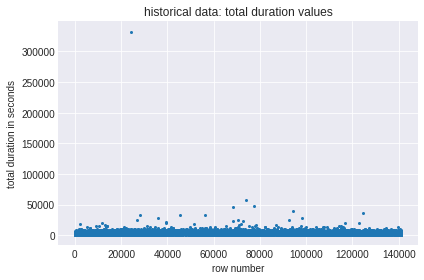

In [0]:
# data quality 
# remove rows that have negative total duration from training data set
condition = (training_fw.data['total_duration'] > 0)
training_fw.update_data(training_fw.data[condition])

# inspect total duration data
y = training_fw.data['total_duration']
x = range(len(y))
plt.scatter(x, y, s=4)
plt.xlabel('row number')
plt.ylabel('total duration in seconds')
plt.title('historical data: total duration values')
plt.tight_layout()

# save plot
# plt.savefig(path + 'total_duration_input_data.jpg', dpi=200)
plt.show()

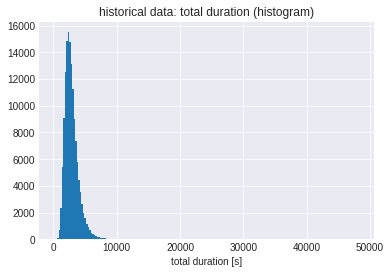

In [0]:
""" observation: there are data points with total duration > 300.000s ~ 80h

consider these as unreasonable and remove any values < 50000 (14h) from data set
and inspect distribution in histogram
"""

condition = (training_fw.data['total_duration'] < 50000)
training_fw.update_data(training_fw.data[condition])

# plot histogram of cropped training data set
y = training_fw.data['total_duration']
plt.hist(y, bins=200)
plt.xlabel('total duration [s]')
plt.title('historical data: total duration (histogram)')
plt.show()

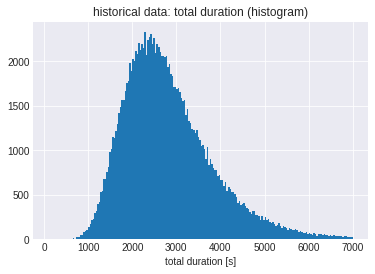

In [0]:
""" observations: total duration values above 7000s (~2h) seem to be rare events

consider those as outliers and remove from data set and re-evaluate histogram
"""

condition = (training_fw.data['total_duration'] < 7000)
training_fw.update_data(training_fw.data[condition])

y = training_fw.data['total_duration']
plt.hist(y, bins=200)
plt.title('historical data: total duration (histogram)')
plt.xlabel('total duration [s]')
# save figure
#plt.savefig(path + 'total_duration_cleaned_histogram.jpg', dpi=200)
plt.show()

# distribution looks like a Poisson distribution
# not unexpected: series of discrete events where the current event is independent
#                 of the previous one (and the average 'rate' of arrival is known)

In [0]:
# inspect values for short durations

print(sorted(training_fw.data['total_duration'])[0:10])

""" observations

a few very short total delivery times are found in the data set; 3 data points 
with less than 5 minutes delivery time. The shortest delivery time is ~2 min 
which is not unrealistic
"""

[101.0, 223.0, 297.0, 321.0, 325.0, 352.0, 386.0, 406.0, 429.0, 470.0]


' observations\n\na few very short total delivery times are found in the data set; 3 data points \nwith less than 5 minutes delivery time. The shortest delivery time is ~2 min \nwhich is not unrealistic\n'

# Section 3: feature exploration

3.1 data exploration: correlation analysis of features with predictor variable



**3.1 correlation analysis**

- for each feature in the training data set, get absolute value of the correlation between the feature and the total duration time

In [0]:
# discriminate between numerical and categorical features

features_numerical = ['total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_drivers', 'total_busy_drivers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration']

features_categorical = ['market_id', 'store_id', 'store_primary_category']

target_feature = ['total_duration']
df_tmp = copy.deepcopy(training_fw.data)

dict_numerical = {}  # initialize results dictionary
for feature in features_numerical:
  cols = target_feature + list([feature])
  df = df_tmp[cols]
  corr_coeff_mx = df.corr(method='spearman')  # get correlation coefficient 
  abs_corr_coeff = np.abs(np.array(corr_coeff_mx)[0][1])
  dict_numerical[feature] = abs_corr_coeff

print('Spearman correlation coefficient btw total duration and selected feature')
dict_numerical


Spearman correlation coefficient btw total duration and selected feature


{'estimated_order_place_duration': 0.1014074065813527,
 'estimated_store_to_consumer_driving_duration': 0.2672785214436824,
 'max_item_price': 0.1664938503730808,
 'min_item_price': 0.003931115304042447,
 'num_distinct_items': 0.16560319727184308,
 'subtotal': 0.23945951049716763,
 'total_busy_drivers': 0.11878314768284352,
 'total_items': 0.15851174336817217,
 'total_onshift_drivers': 0.09387652009854872,
 'total_outstanding_orders': 0.19123763244706182}

In [0]:
"""
observation: estimated store to consumer driving duration has the largest 
correlation coefficient with the total duration, followed by the subtotal

"""

# analysis for categorical features
dict_categorical = {}
for feature in features_categorical:
  if feature == 'store_id':
    print('skip store_id as there are many for the encoder to respond in a \
    reasonable time')
  else:
    # print(feature)
    df_tmp = copy.deepcopy(training_fw.data)
    # encode categorical variable; use pandas dummy encoder
    df_dummies = pd.get_dummies(df_tmp[feature])
    del df_dummies[df_dummies.columns[-1]]
    df_tmp = pd.concat([df_tmp, df_dummies], axis=1)
    del df_tmp[feature]

    abs_corr_coeffs = []
    for new_feature in df_dummies.columns:
      cols = target_feature + list([new_feature])
      df = df_tmp[cols]
      df = df.dropna()  # drop NaN values
      corr_coeff_mx = df.corr(method='spearman')
      abs_corr_coeff = np.abs(np.array(corr_coeff_mx)[0][1])
      abs_corr_coeffs.append(abs_corr_coeff)

    # take average of correlation coefficients
    dict_categorical[feature] = np.mean(abs_corr_coeffs)
      
print('Spearman correlation coefficient btw total duration and selected feature')
dict_categorical

skip store_id as there are many for the encoder to respond in a     reasonable time
Spearman correlation coefficient btw total duration and selected feature


{'market_id': 0.03168299088814317,
 'store_primary_category': 0.010443271893570423}

In [0]:
"""
observation: out of the categorical variables, the order protocol has the largest
correlation with the total duration

"""

dict_numerical.update(dict_categorical)
print('absolute correlation coefficients between features and total duration')

# print all correlation coefficients
sorted(dict_numerical.items(), key=lambda item: item[1], reverse=True)

absolute correlation coefficients between features and total duration


[('estimated_store_to_consumer_driving_duration', 0.2672785214436824),
 ('subtotal', 0.23945951049716763),
 ('total_outstanding_orders', 0.19123763244706182),
 ('max_item_price', 0.1664938503730808),
 ('num_distinct_items', 0.16560319727184308),
 ('total_items', 0.15851174336817217),
 ('total_busy_drivers', 0.11878314768284352),
 ('estimated_order_place_duration', 0.1014074065813527),
 ('total_onshift_drivers', 0.09387652009854872),
 ('market_id', 0.03168299088814317),
 ('store_primary_category', 0.010443271893570423),
 ('min_item_price', 0.003931115304042447)]

# Section 4: run model on initial features selection (estimated order place duration and store to customer times)

4.1 inpect the first selected features' data 
(estimated order place and store to consumer duration)


4.2 clean data if necessary

4.3 train, predict and evaluate model

**4.1 data inspection**

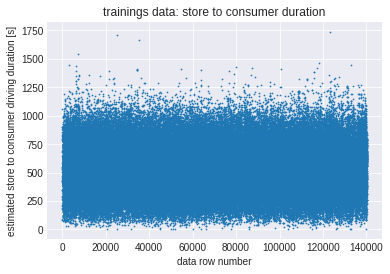

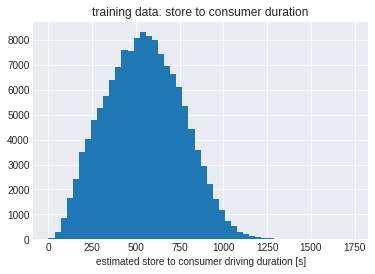

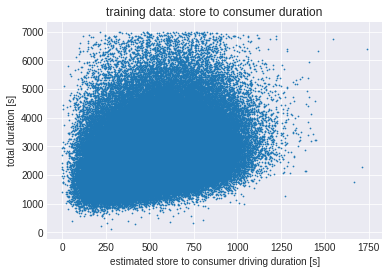

In [0]:
4.1
# inspect estimated order place duration and store to consumer driving duration
# in both training as well as testing data set
size = 0.5  # scatter plot dot size

y = training_fw.data['estimated_order_place_duration'].values
x = range(len(y))
plt.scatter(x, y, s=8*size)
plt.ylabel('estimated order place duration [s]')
plt.xlabel('data row number')
plt.title('training data: order place duration')
# plt.show()
plt.close()

y = testing_fw.data['estimated_order_place_duration'].values
x = range(len(y))
plt.scatter(x, y, s=8*size)
plt.ylabel('estimated order place duration [s]')
plt.xlabel('data row number')
plt.title('testing data: order place duration')
# plt.show()
plt.close()

y = training_fw.data['estimated_store_to_consumer_driving_duration'].values
x = range(len(y))
plt.scatter(x, y, s=size)
plt.ylabel('estimated store to consumer driving duration [s]')
plt.xlabel('data row number')
plt.title('trainings data: store to consumer duration')
plt.show()
plt.close()
plt.hist(y, bins=50)
plt.xlabel('estimated store to consumer driving duration [s]')
plt.title('training data: store to consumer duration')
plt.show()
plt.close()

x = training_fw.data['estimated_store_to_consumer_driving_duration'].values
y = training_fw.data['total_duration'].values
plt.scatter(x, y, s=size)
plt.xlabel('estimated store to consumer driving duration [s]')
plt.ylabel('total duration [s]')
plt.title('training data: store to consumer duration')
plt.show()
plt.close()

y = testing_fw.data['estimated_store_to_consumer_driving_duration'].values
x = range(len(y))
plt.scatter(x, y, s=size)
plt.ylabel('estimated store to consumer driving duration [s]')
plt.xlabel('data row number')
plt.title('testing data: store to consumer duration')
# plt.show()
plt.close()
plt.hist(y[~np.isnan(y)], bins=50)
plt.xlabel('estimated store to consumer driving duration [s]')
plt.title('testing data: store to consumer duration')
# plt.show()
plt.close()



**4.2 data cleaning**

In [0]:
""" observation: both data sets have some negative values for both estimated
driving duration as well as order place duration

consider these unreasonable and remove from data sets

"""


for fw in frameworks:
  condition = (fw.data['estimated_order_place_duration'] > 0) & \
  (fw.data['estimated_store_to_consumer_driving_duration'] > 0)
  fw.update_data(fw.data[condition])

# check what percentage of data has been dropped so far
print('percentage data dropped from training set'
      , training_fw.check_dropped_data())

# print('percentage data dropped from testing set'
      # , training_fw.check_dropped_data())

# consider remaining data still sufficient for 

number of rows in raw data set:  140107
percentage data dropped from training set 11.508946560642707


**4.3: Train, Predict and Evaluate**

initial selection of features
- choose estimated order place duration and estimated store to consumer duration as independent variables
- fit model and get performance metrics


In the first stage, only include features from 
estimation model into analysis

In [0]:
# select features to include in model fitting

# start with features from estimation model only
selected_features = ['estimated_order_place_duration', 
                     'estimated_store_to_consumer_driving_duration']

target = ['total_duration']

# evaluate model
training_fw.evaluate_model(selected_features=selected_features, target=target)

average mean absolute error:  751.38
R-squared value:  0.0716
Adjusted R-squared value:  0.0715


# Section 5: add 'market' features

5.1 inspect data for 'market' features: outstanding orders, busy and onshift drivers

5.2 clean data: replace missing data, remove outliers and anomalies

5.3 train, predict and evaluate model

**5.1 Add 'market' features**

- inspect data for these features in both training data as well as testing data set
- if necessary, clean training data and preprocess testing data

In [0]:
# check in training and testing data set whether there are data points with 
# values smaller than zero

features = ['total_busy_drivers', 'total_onshift_drivers']

for feature in features:
  for i, fw in enumerate(frameworks):
    condition = (fw.data[feature] < 0)
    if i==0: 
      print('training data')
    else: 
      print('testing data')
    print('Number of data points where feature ' + str(feature) + 
          ' value less than zero:' , fw.data[feature][condition].shape[0])
    print('distinct values are: ', set(fw.data[feature][condition]))


"""
observation: both data sets have values for number of drivers < 0

for prediction data set: take mean value of the two neighboring data points
for training data set: delete rows that fulfil this condition

"""

training data
Number of data points where feature total_busy_drivers value less than zero: 17
distinct values are:  {-2.0, -5.0, -4.0, -3.0, -1.0}
testing data
Number of data points where feature total_busy_drivers value less than zero: 4
distinct values are:  {-1.0, -2.0}
training data
Number of data points where feature total_onshift_drivers value less than zero: 16
distinct values are:  {-3.0, -2.0, -1.0}
testing data
Number of data points where feature total_onshift_drivers value less than zero: 5
distinct values are:  {-4.0, -2.0, -1.0}


'\nobservation: both data sets have values for number of drivers < 0\n\nfor prediction data set: take mean value of the two neighboring data points\nfor training data set: delete rows that fulfil this condition\n\n'

**5.2 clean data**

- replace NaN values with averages (testing data)
- remove unreasonable values (training data)

In [0]:
# testing data: replace negative values for above two features first with
# NaN values and then all NaN values with mean value of neighboring two values

for feature in features:
  for fw in [testing_fw]:
    condition = (fw.data[feature] < 0)
    df_tmp = copy.deepcopy(fw.data)

    # replace vals with NaNs
    if feature == 'total_busy_drivers':
      # manually setup dictionary; could be automized
      dict_replacements = {-5.0: np.NaN, -4.0: np.NaN, -3.0: np.NaN, 
                          -2.0: np.NaN, -1.0: np.NaN}  
      df_tmp.total_busy_drivers = \
        df_tmp.total_busy_drivers.replace(dict_replacements)

    if feature == 'total_onshift_drivers':
      # manually setup dictionary; could be automized
      dict_replacements = {-4.0: np.NaN, -3.0: np.NaN, 
                          -2.0: np.NaN, -1.0: np.NaN} 
      df_tmp.total_onshift_drivers = \
      df_tmp.total_onshift_drivers.replace(dict_replacements)

    # if feature == 'total_outstanding_orders':
    #   # manually setup dictionary; could be automized
    #   dict_replacements = {-6.0: np.NaN, -5.0: np.NaN, -4.0: np.NaN, 
    #                       -3.0: np.NaN, -2.0: np.NaN, -1.0: np.NaN} 
    #   df_tmp.total_outstanding_orders = \
    #   df_tmp.total_outstanding_orders.replace(dict_replacements)

    fw.update_data(df_tmp)

    # fill all NaNs with mean of neighboring data points
    vals_tmp = fw.data[feature]
    vals_tmp = (vals_tmp.ffill() + vals_tmp.bfill())/2
    print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

    # put cleaned data into framework data
    dict_ = dict(fw.data)
    dict_[feature] = vals_tmp
    df_tmp = pd.DataFrame(dict_)
    fw.update_data(df_tmp)


Are all NaNs overridden?  True
Are all NaNs overridden?  True


In [0]:
# training data: only consider data where the number of total onshift and 
# busy drivers is greater or equal to zero

for feature in features:
  condition = (training_fw.data[feature] >= 0)
  training_fw.update_data(training_fw.data[condition])

# check amount of data dropped
print('percentage data dropped from training set'
, training_fw.check_dropped_data())

# available data considered sufficiently big enough

number of rows in raw data set:  140075
percentage data dropped from training set 11.529157640103838


inspect data for this feature

total_busy_drivers


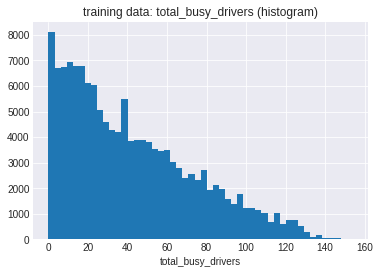

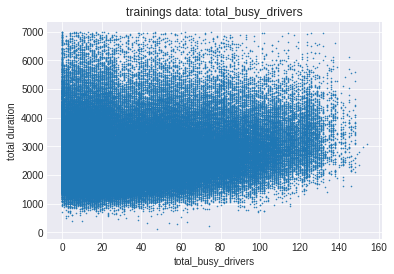

total_onshift_drivers


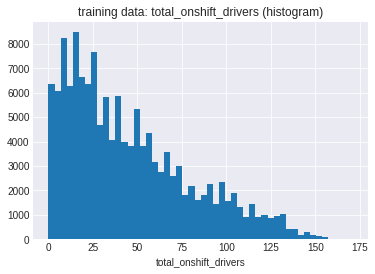

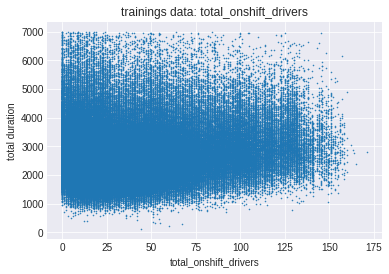

In [0]:
# visual inspection of total onshift and busy drivers for anomalies in both
# data sets
size = 0.3

for feature in features:
  print(feature)
  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('trainings data: ' + feature)
  # plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.xlabel(feature)
  plt.title('training data: ' + feature + ' (histogram)')
  plt.show()
  plt.close()

  x = training_fw.data[feature].values
  y = training_fw.data['total_duration'].values
  plt.scatter(x, y, s=size)
  plt.xlabel(feature)
  plt.ylabel('total duration')
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()

  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('testing data: ' + feature)
  # plt.show()
  plt.close()
  plt.hist(y[~np.isnan(y)], bins=50)
  plt.xlabel(feature)
  plt.title('testing data: ' + feature + ' (histogram)')
  # plt.show()
  plt.close()

In [0]:
for feature in features:
  condition = (training_fw.data[feature] < 0)
  df_tmp = copy.deepcopy(training_fw.data)

  # replace vals with NaNs
  if feature == 'total_busy_drivers':
    dict_replacements = {-4.0: np.NaN, -3.0: np.NaN, -2.0: np.NaN, 
                         -1.0: np.NaN}
    df_tmp.total_busy_drivers = \
      df_tmp.total_busy_drivers.replace(dict_replacements)

  if feature == 'total_onshift_drivers':
    dict_replacements = {-1.0: np.NaN}
    df_tmp.total_onshift_drivers = \
     df_tmp.total_onshift_drivers.replace(dict_replacements)

  training_fw.update_data(df_tmp)

  # fill all NaNs with mean of neighboring data points
  vals_tmp = training_fw.data[feature]
  vals_tmp = (vals_tmp.ffill() + vals_tmp.bfill())/2
  print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

  # put cleaned data into framework data
  dict_ = dict(training_fw.data)
  dict_[feature] = vals_tmp
  df_tmp = pd.DataFrame(dict_)
  training_fw.update_data(df_tmp)


Are all NaNs overridden?  True
Are all NaNs overridden?  True


In [0]:
"""
observations: no visual outliers or anomalies in above plots

"""

# take difference between total number of busy and onshift drivers to get total 
# number of available drivers
# label this new feature 'total_available_drivers' and add this to both data sets

for fw in frameworks:
  total_available_drivers = fw.data['total_onshift_drivers'] \
                            - fw.data['total_busy_drivers']
  dict_ = dict(fw.data)
  dict_['total_available_drivers'] = total_available_drivers
  df_tmp = pd.DataFrame(dict_)
  fw.update_data(df_tmp)

**5.3 Evaluate model with added feature**

In [0]:
# evaluate model with added feature 'total_available_drivers'

selected_features.append('total_available_drivers')
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)

current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers']
average mean absolute error:  750.69
R-squared value:  0.0736
Adjusted R-squared value:  0.0734


In [0]:

dict_numerical.update(dict_categorical)
print('absolute correlation coefficients between features and total duration')

# print all correlation coefficients
sorted(dict_numerical.items(), key=lambda item: item[1], reverse=True)

absolute correlation coefficients between features and total duration


[('estimated_store_to_consumer_driving_duration', 0.2672785214436824),
 ('subtotal', 0.23945951049716763),
 ('total_outstanding_orders', 0.19123763244706182),
 ('max_item_price', 0.1664938503730808),
 ('num_distinct_items', 0.16560319727184308),
 ('total_items', 0.15851174336817217),
 ('total_busy_drivers', 0.11878314768284352),
 ('estimated_order_place_duration', 0.1014074065813527),
 ('total_onshift_drivers', 0.09387652009854872),
 ('market_id', 0.03168299088814317),
 ('store_primary_category', 0.010443271893570423),
 ('min_item_price', 0.003931115304042447)]

# Section 6: add more 'market' features

6.1 analyze additional feature: outstanding orders

6.2 preprocess data: check availability of categorical feature in both training as well as testing data set

6.3 clean data

6.4 train, predict and evaluate model


**6.1 analyze feature data**

total_outstanding_orders


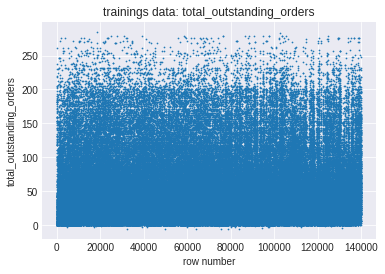

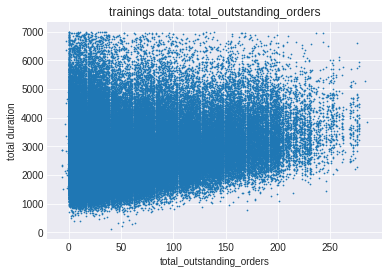

In [0]:
"""
observation: adjusted R-squared value still around 0.7

inspect data for 'total_outstanding_orders', clean and preprocess, 
add to selected features and re-evaluate model
"""

# visual inspection of total outstanding orders for anomalies in both data sets
features = ['total_outstanding_orders']

size = 0.5  # scatter plot dot size

for feature in features:
  print(feature)
  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.xlabel(feature)
  plt.title('training data: ' + feature)
  # plt.show()
  plt.close()

  x = training_fw.data[feature].values
  y = training_fw.data['total_duration'].values
  plt.scatter(x, y, s=size)
  plt.xlabel(feature)
  plt.ylabel('total duration')
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()

  y = testing_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('testing data: ' + feature)
  # plt.show()
  plt.close()
  plt.hist(y[~np.isnan(y)], bins=50)
  plt.xlabel(feature)
  plt.title('testing data: ' + feature)
  # plt.show()
  plt.close()


**6.2 data quality inspection**

In [0]:
# check in training and testing data set whether there are data points with 
# values for total outstanding orders that are smaller than zero

for feature in features:
  for i, fw in enumerate(frameworks):
    condition = (fw.data[feature] < 0)
    if i==0: 
      print('training data')
    else: 
      print('testing data')
    print('Number of data points where feature ' + str(feature) + 
          ' value less than zero:' , fw.data[feature][condition].shape[0])
    print('distinct values are: ', set(fw.data[feature][condition]))


"""
observation: both data sets have values for total outstanding orders < 0

for prediction data set: replace negative values with zero
for training data set: delete rows that fulfil this condition

"""

training data
Number of data points where feature total_outstanding_orders value less than zero: 29
distinct values are:  {-1.0, -6.0, -5.0, -4.0, -3.0, -2.0}
testing data
Number of data points where feature total_outstanding_orders value less than zero: 8
distinct values are:  {-5.0, -3.0, -1.0, -2.0}


'\nobservation: both data sets have values for total outstanding orders < 0\n\nfor prediction data set: replace negative values with zero\nfor training data set: delete rows that fulfil this condition\n\n'

**6.3 data cleaning**

In [0]:
# testing data set: replace negative values for feature with zeros and replace
# NaN values with mean values

df_tmp = copy.deepcopy(testing_fw.data)

# replace vals with zeros
dict_replacements = {-9.0: 0, -5.0: 0, -4.0: 0, -3.0: 0, -2.0: 0, -1.0: 0}
df_tmp.total_outstanding_orders = \
    df_tmp.total_outstanding_orders.replace(dict_replacements)

# update framework
testing_fw.update_data(df_tmp)

feature = 'total_outstanding_orders'
# check if there are NaNs:
print('NaN values in data for total outstanding order? ',
      df_tmp[feature].isnull().sum() != 0)

# fill NaN values with mean values
vals_tmp = df_tmp[feature].fillna(df_tmp[feature].mean())
print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

# put cleaned data into framework data
dict_ = dict(df_tmp)
dict_[feature] = vals_tmp
df_tmp = pd.DataFrame(dict_)
testing_fw.update_data(df_tmp)


NaN values in data for total outstanding order?  True
Are all NaNs overridden?  True


In [0]:
# training data set: only consider data that has values greater than zero
# for this feature 

condition = (training_fw.data[feature] >= 0)
training_fw.update_data(training_fw.data[condition])

# check amount of data dropped
print('percentage data dropped from training set'
, training_fw.check_dropped_data())

# amount of data still considered sufficient

# To check results: rerun above analysis on negative values

number of rows in raw data set:  140046
percentage data dropped from training set 11.547473930865483


**6.4 evaluate model with added feature**

In [0]:
# evaluate model with added feature 'total_outstanding_orders'

selected_features.append('total_outstanding_orders')
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)

current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers', 'total_outstanding_orders']
average mean absolute error:  720.98
R-squared value:  0.1282
Adjusted R-squared value:  0.128


In [0]:
print('absolute correlation coefficients between features and total duration')

# print all correlation coefficients
sorted(dict_numerical.items(), key=lambda item: item[1], reverse=True)

absolute correlation coefficients between features and total duration


[('estimated_store_to_consumer_driving_duration', 0.2672785214436824),
 ('subtotal', 0.23945951049716763),
 ('total_outstanding_orders', 0.19123763244706182),
 ('max_item_price', 0.1664938503730808),
 ('num_distinct_items', 0.16560319727184308),
 ('total_items', 0.15851174336817217),
 ('total_busy_drivers', 0.11878314768284352),
 ('estimated_order_place_duration', 0.1014074065813527),
 ('total_onshift_drivers', 0.09387652009854872),
 ('market_id', 0.03168299088814317),
 ('store_primary_category', 0.010443271893570423),
 ('min_item_price', 0.003931115304042447)]

# Section 7: add 'order' features

7.1 analyze additional features: subtotal, maximum item price, number of distinct items

7.2 inspect data quality

7.3 clean data

7.4 train, predict and evalute model



**7.1 inspect added feature data**


subtotal


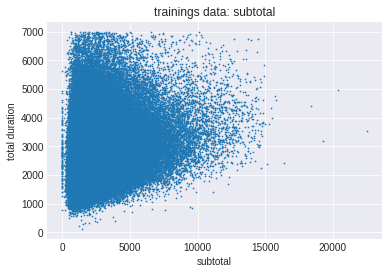

max_item_price


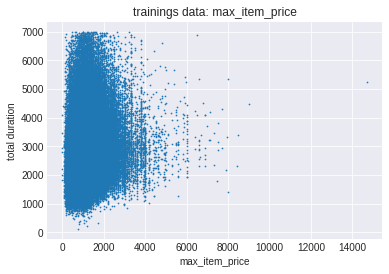

num_distinct_items


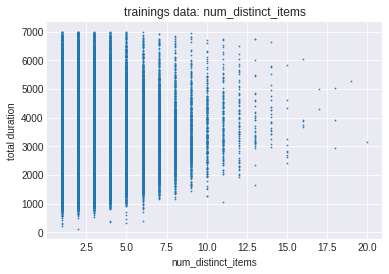

In [0]:
"""
inspect data for 'subtotal', 'max_item_price', 'num_distinct_items', 'total_items'
clean and preprocess data
add to selected features and re-evaluate model
"""

# visual inspection of total outstanding orders for anomalies in both data sets
features = ['subtotal', 'max_item_price', 'num_distinct_items', 'total_items']

size = 0.5  # scatter plot dot size

for feature in features[0:3]:
  print(feature)
  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('trainings data: ' + feature)
  # plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.xlabel(feature)
  plt.title('training data: ' + feature)
  # plt.show()
  plt.close()

  x = training_fw.data[feature].values
  y = training_fw.data['total_duration'].values
  plt.scatter(x, y, s=size)
  plt.xlabel(feature)
  plt.ylabel('total duration')
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()

  y = testing_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y, s=size)
  plt.xlabel('row number')
  plt.ylabel(feature)
  plt.title('testing data: ' + feature)
  # plt.show()
  plt.close()
  plt.hist(y[~np.isnan(y)], bins=50)
  plt.xlabel(feature)
  plt.title('testing data: ' + feature)
  # plt.show()
  plt.close()


**7.2 data quality inspection**

In [0]:
# check in training and testing data set whether there are data points with 
# values for total outstanding orders that are smaller than zero

for feature in features:
  for i, fw in enumerate(frameworks):
    condition = (fw.data[feature] < 0)
    if i==0: 
      print('training data')
    else: 
      print('testing data')
    print('Number of data points where feature ' + str(feature) + 
          ' value less than zero:' , fw.data[feature][condition].shape[0])
    # print('distinct values are: ', set(fw.data[feature][condition]))


"""
observation: no data quality issues
"""

training data
Number of data points where feature subtotal value less than zero: 0
testing data
Number of data points where feature subtotal value less than zero: 0
training data
Number of data points where feature max_item_price value less than zero: 0
testing data
Number of data points where feature max_item_price value less than zero: 0
training data
Number of data points where feature num_distinct_items value less than zero: 0
testing data
Number of data points where feature num_distinct_items value less than zero: 0
training data
Number of data points where feature total_items value less than zero: 0
testing data
Number of data points where feature total_items value less than zero: 0


'\nobservation: no data quality issues\n'

**7.3 data cleaning**

In [0]:
# no outliers found; take data as is

**7.4 evaluate model with added features**

In [0]:
# evaluate model with added feature

selected_features.extend(['subtotal', 'max_item_price', 
                          'num_distinct_items', 'total_items'])
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)

current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers', 'total_outstanding_orders', 'subtotal', 'max_item_price', 'num_distinct_items', 'total_items']
average mean absolute error:  702.37
R-squared value:  0.1661
Adjusted R-squared value:  0.1656


In [0]:
print('absolute correlation coefficients between features and total duration')

# print all correlation coefficients
sorted(dict_numerical.items(), key=lambda item: item[1], reverse=True)

absolute correlation coefficients between features and total duration


[('estimated_store_to_consumer_driving_duration', 0.2672785214436824),
 ('subtotal', 0.23945951049716763),
 ('total_outstanding_orders', 0.19123763244706182),
 ('max_item_price', 0.1664938503730808),
 ('num_distinct_items', 0.16560319727184308),
 ('total_items', 0.15851174336817217),
 ('total_busy_drivers', 0.11878314768284352),
 ('estimated_order_place_duration', 0.1014074065813527),
 ('total_onshift_drivers', 0.09387652009854872),
 ('market_id', 0.03168299088814317),
 ('store_primary_category', 0.010443271893570423),
 ('min_item_price', 0.003931115304042447)]

# Section 8: add 'time' (location) features: market ID

8.1 analyze additional features: location of store and customer (market ID)

8.2 inspect data quality

8.3 clean data

8.4 train, predict and evalute model



**8.1 inspect additional feature data**

In [0]:
"""
observation: Adjusted R-squared value increased from 0.12 to 0.16

try to include more features and see whether the R-squared value inceases

As a next step, include the market_id into the analysis 
This is considered a cagetorical variable, not an ordinal one and will need 
encoding

"""

# check how many distinct market_ids are in both data sets
feature = 'market_id' 

for i, fw in enumerate(frameworks):
  if i==0:
    print('training data set')
  else:
    print('testing data set')

  print('number of distinct values are: ', len(sorted(set(fw.data[feature]))))
  print('distinct values are: ', sorted(set(fw.data[feature])))


training data set
number of distinct values are:  6
distinct values are:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
testing data set
number of distinct values are:  188
distinct values are:  [nan, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 6.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

**8.2 data quality inspection**

In [0]:
"""
observation: 
  - training data set has no NaNs, while testing data set has NaNs
  - all distinct non-NaN values are the same in testing and training data set

inspect testing data set further on how many NaNs are there
"""

# number of nans and total number of teting data set rown
print('NaNs for feature in testing data set', 
      testing_fw.data[feature].isnull().sum())
print('total number of rows in testing data set', testing_fw.data.shape[0])


NaNs for feature in testing data set 182
total number of rows in testing data set 38967


**8.3 data cleaning**

In [0]:
"""
observation: total number of NaNs is less than 1% of the total data 

find most common market_id in training and testing data set 
"""
for i, fw in enumerate(frameworks):
  if i==0:
    print('training data')
  else:
    print('testing data')

  df_tmp = copy.deepcopy(fw.data)
  print(df_tmp.groupby(feature)['created_at'].nunique())

training data
market_id
1.0    29307
2.0    42156
3.0    16988
4.0    36055
5.0    12878
6.0      521
Name: created_at, dtype: int64
testing data
market_id
1.0     7183
2.0    10387
3.0     4172
4.0     9689
5.0     4350
6.0     2853
Name: created_at, dtype: int64


In [0]:
"""
observation: most common market_id is 2.0 in both data sets

replace NaN values in testing data set with 2.0
"""

df_tmp = copy.deepcopy(testing_fw.data)
df_tmp['market_id'].fillna(2.0, inplace=True)

testing_fw.update_data(df_tmp)

# to check that all nans are actually replaced, execute statement above where
# distinct number of values are obtained

In [0]:
# first replace integer values for market_ids with strings using the mapping given 
# in the dictionary below
# then use dummy (one-hot) encoding for the categorical market_id variable and
# apply to both data sets

dict_replacements = {1.0: 'city_1', 2.0: 'city_2', 3.0: 'city_3', 4.0: 'city_4',
                  5.0: 'city_5', 6.0: 'city_6'}
                  
for fw in frameworks:
  df_tmp = copy.deepcopy(fw.data)
  df_tmp.market_id = df_tmp.market_id.replace(dict_replacements)
  dummies = pd.get_dummies(df_tmp.market_id)
  df_tmp = df_tmp.join(dummies)
  fw.update_data(df_tmp)

**8.4 evalute model with added feature**



In [0]:
# evaluate model with added features 'city_1', ..., 'city_6'
features_market_id = list(dict_replacements.values())
selected_features.extend(features_market_id)
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)


current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers', 'total_outstanding_orders', 'subtotal', 'max_item_price', 'num_distinct_items', 'total_items', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6']
average mean absolute error:  687.74
R-squared value:  0.2004
Adjusted R-squared value:  0.1996


In [0]:
print('absolute correlation coefficients between features and total duration')

# print all correlation coefficients
sorted(dict_numerical.items(), key=lambda item: item[1], reverse=True)

absolute correlation coefficients between features and total duration


[('estimated_store_to_consumer_driving_duration', 0.2672785214436824),
 ('subtotal', 0.23945951049716763),
 ('total_outstanding_orders', 0.19123763244706182),
 ('max_item_price', 0.1664938503730808),
 ('num_distinct_items', 0.16560319727184308),
 ('total_items', 0.15851174336817217),
 ('total_busy_drivers', 0.11878314768284352),
 ('estimated_order_place_duration', 0.1014074065813527),
 ('total_onshift_drivers', 0.09387652009854872),
 ('market_id', 0.03168299088814317),
 ('store_primary_category', 0.010443271893570423),
 ('min_item_price', 0.003931115304042447)]

# Section 9: remaining feature inspection, store category and store ID


**9.1 inspect additional features**

In [0]:
"""
observation: R-squared value increased to 0.20; MAE dropped to 687

- keep feature in analysis
- add the store features to the analysis
"""

# inspect data in both data sets for the feature 'store_primary_category'

# get distinct restaurant types are in both data sets
training_store_categories = set(training_fw.data['store_primary_category'])
print('store categories in training set: ', training_store_categories)
testing_store_categories = set(testing_fw.data['store_primary_category'])
print('store categories in testing set: ', testing_store_categories)

# get restaurant types in the testing set that are not in the training set 
# and vice versa

print('store categories in training set but not in testing set')
print(list(training_store_categories - testing_store_categories))
print('store categories in testing set but not in training set')
print(list(testing_store_categories - training_store_categories))


# inspect data in both data sets for the feature 'store_id'

# get distinct restaurant types are in both data sets
training_store_id = set(training_fw.data['store_id'])
print('store IDs in training set: ', training_store_id)
print('number of store IDs in training set:', len(training_store_id))
testing_store_id = set(testing_fw.data['store_id'])
print('store IDs in testing set: ', testing_store_id)
print('number of store IDs in testing set:', len(testing_store_id))

# get restaurant types in the testing set that are not in the training set and
# vice versa

print('store IDs in training set but not in testing set')
store_ids_not_in_testing_set = list(training_store_id - testing_store_id)
print(store_ids_not_in_testing_set)
print('number of store IDs not in testing set: ', 
      len(store_ids_not_in_testing_set))

store_ids_not_in_training_set = list(testing_store_id - training_store_id)
print('store IDs in testing set but not in training set')
print(store_ids_not_in_training_set)
print('number of store IDs not in training set: ', 
      len(store_ids_not_in_training_set))


store categories in training set:  {'vietnamese', 'breakfast', 'burger', 'kosher', 'turkish', 'steak', 'italian', 'barbecue', 'korean', 'seafood', 'dim-sum', 'german', 'french', 'alcohol', 'mediterranean', 'catering', 'persian', 'vegetarian', 'japanese', 'soup', 'brazilian', 'spanish', 'russian', 'sushi', 'lebanese', 'belgian', 'afghan', 'european', 'southern', 'sandwich', 'chocolate', 'filipino', 'ethiopian', 'tapas', 'vegan', 'pasta', 'burmese', 'bubble-tea', 'peruvian', 'convenience-store', 'greek', 'american', 'nepalese', 'latin-american', 'fast', 'comfort-food', 'thai', 'african', 'alcohol-plus-food', 'salad', 'british', 'singaporean', 'cajun', 'gastropub', 'argentine', 'middle-eastern', 'pakistani', 'gluten-free', 'other', 'caribbean', 'moroccan', 'smoothie', 'mexican', 'dessert', 'indian', 'irish', 'pizza', 'hawaiian', 'cafe', 'asian', 'cheese', 'chinese', 'malaysian'}
store categories in testing set:  {nan, 'vietnamese', 'breakfast', 'burger', 'turkish', 'steak', 'italian', 'ko

further inspect additional features

In [0]:
"""
observations:
for store categories:
- lots of different categories
- not all of them are in the testing set
- CAREFUL: categories might be 'nested', ie 'barbeque' and 'soup' might be 
           a subcategory of for example 'japanese'

DO NOT ADD store category to the list of selected features bc of above mentioned
possible nesting and its relatively low correlation with the total duration


for store IDs:
- the number of store IDs that are in the training data set but not in the
  testing data set are of the order of 20% of the set of store IDs found in 
  the testing data set

DO NOT ADD the store ID to the model features because too many non-common values
between testing and training data set and the relatively low correlation 
between the store ID and the total duration


"""


"\nobservations:\nfor store categories:\n- lots of different categories\n- not all of them are in the testing set\n- CAREFUL: categories might be 'nested', ie 'barbeque' and 'soup' might be \n           a subcategory of for example 'japanese'\n\nDO NOT ADD store category to the list of selected features bc of above mentioned\npossible nesting and its relatively low correlation with the total duration\n\n\nfor store IDs:\n- the number of store IDs that are in the training data set but not in the\n  testing data set are of the order of 20% of the set of store IDs found in \n  the testing data set\n\nDO NOT ADD the store ID to the model features because too many non-common values\nbetween testing and training data set and the relatively low correlation \nbetween the store ID and the total duration\n\n\n"

# Section 10: Apply fitted model to testing data set and forecast total duration times in testing set

In [0]:
# get scaler from training framework and apply to testing data set

scaler = training_fw.get_scaler()
df_tmp = testing_fw.data
df_tmp[selected_features]= scaler.transform(df_tmp[selected_features])

# get trained model and predict duration
model = training_fw.get_model()
predicted_duration = model.predict(df_tmp[selected_features])

In [0]:
# get DataFrame with forecasted and (realized) total duration 

dict_ = dict(df_tmp)
dict_['predicted_duration'] = predicted_duration.flatten()
features = list(df_tmp.columns)

for feature in features:
  if feature not in ['predicted_duration', 'total_duration']:
    dict_.pop(feature)

df_out = pd.DataFrame(data=dict_)
# reduce scope of the total duration to the same as in training set
df_out = df_out[df_out['total_duration'] < 7000]  

#df_out.to_csv(path + 'data_to_predict.csv')

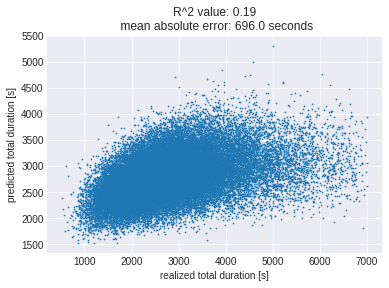

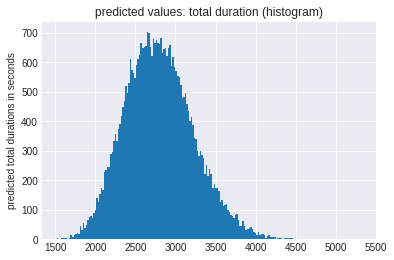

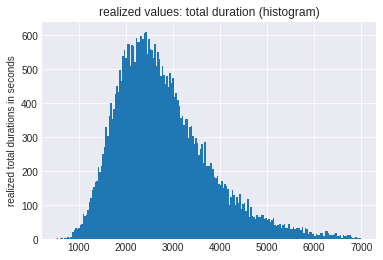

In [0]:
# plot results 
size = 0.5  # scatter plot dot size

x = df_out['total_duration']
y = df_out['predicted_duration']

# get R^2 between realized and predicted values
Rsquared = metrics.r2_score(y_true=x, y_pred=y) 

# mean absolute error
MAE = metrics.mean_absolute_error(x, y)  

plt.scatter(x, y, s=size)
plt.title('R^2 value: ' + str(round(Rsquared,2)) + '\n ' 
          + 'mean absolute error: ' + str(round(MAE,0)) + ' seconds')
plt.xlabel('realized total duration [s]')
plt.ylabel('predicted total duration [s]')
plt.show()
plt.close()
plt.hist(y, bins=200)
plt.title('predicted values: total duration (histogram)')
plt.ylabel('predicted total durations in seconds')
# plt.savefig(path + 'total_duration_prediction_histogram.jpg', dpi=200)
plt.show()
plt.close()

plt.hist(x, bins=200)
plt.title('realized values: total duration (histogram)')
plt.ylabel('realized total durations in seconds')
# plt.savefig(path + 'total_duration_prediction_histogram.jpg', dpi=200)
plt.show()
plt.close()